In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import os

In [57]:
# Load data
train = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction training (with labels).csv')
test  = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction test (without labels).csv')

In [58]:
train.head()

,Instance,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income in EUR
0,1,1997.0,0,41.0,Belarus,1239930,steel workers,Bachelor,0,Blond,193,61031.94416
1,2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,91001.32764
2,3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670
3,4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,45993.75793
4,5,2010.0,female,46.0,United Arab Emirates,95389,lead trainer,0,0,Blond,188,38022.16217


In [59]:
train['Profession'].describe()

count         111671
unique          1340
top       pipefitter
freq             261
Name: Profession, dtype: object

In [60]:
train.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)
test.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)

train = train.replace({ 'Gender': { '0' : 'unknown' } })
test  = test.replace({ 'Gender': { '0': 'unknown' } })

train = train.replace({ 'University Degree': { '0' : 'no', '#NaN': np.nan } })
test  = test.replace({ 'University Degree': { '0': 'no', '#NaN': np.nan } })

train = train.replace({ 'Hair Color': { '0': 'Unknown' } })
test = test.replace({ 'Hair Color': { '0': 'Unknown' } })

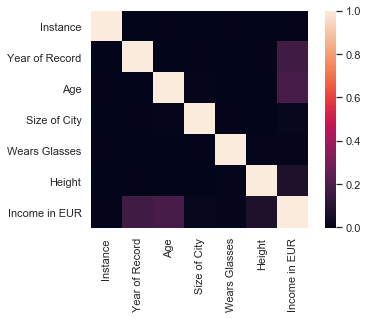

In [61]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corrmat, square=True);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


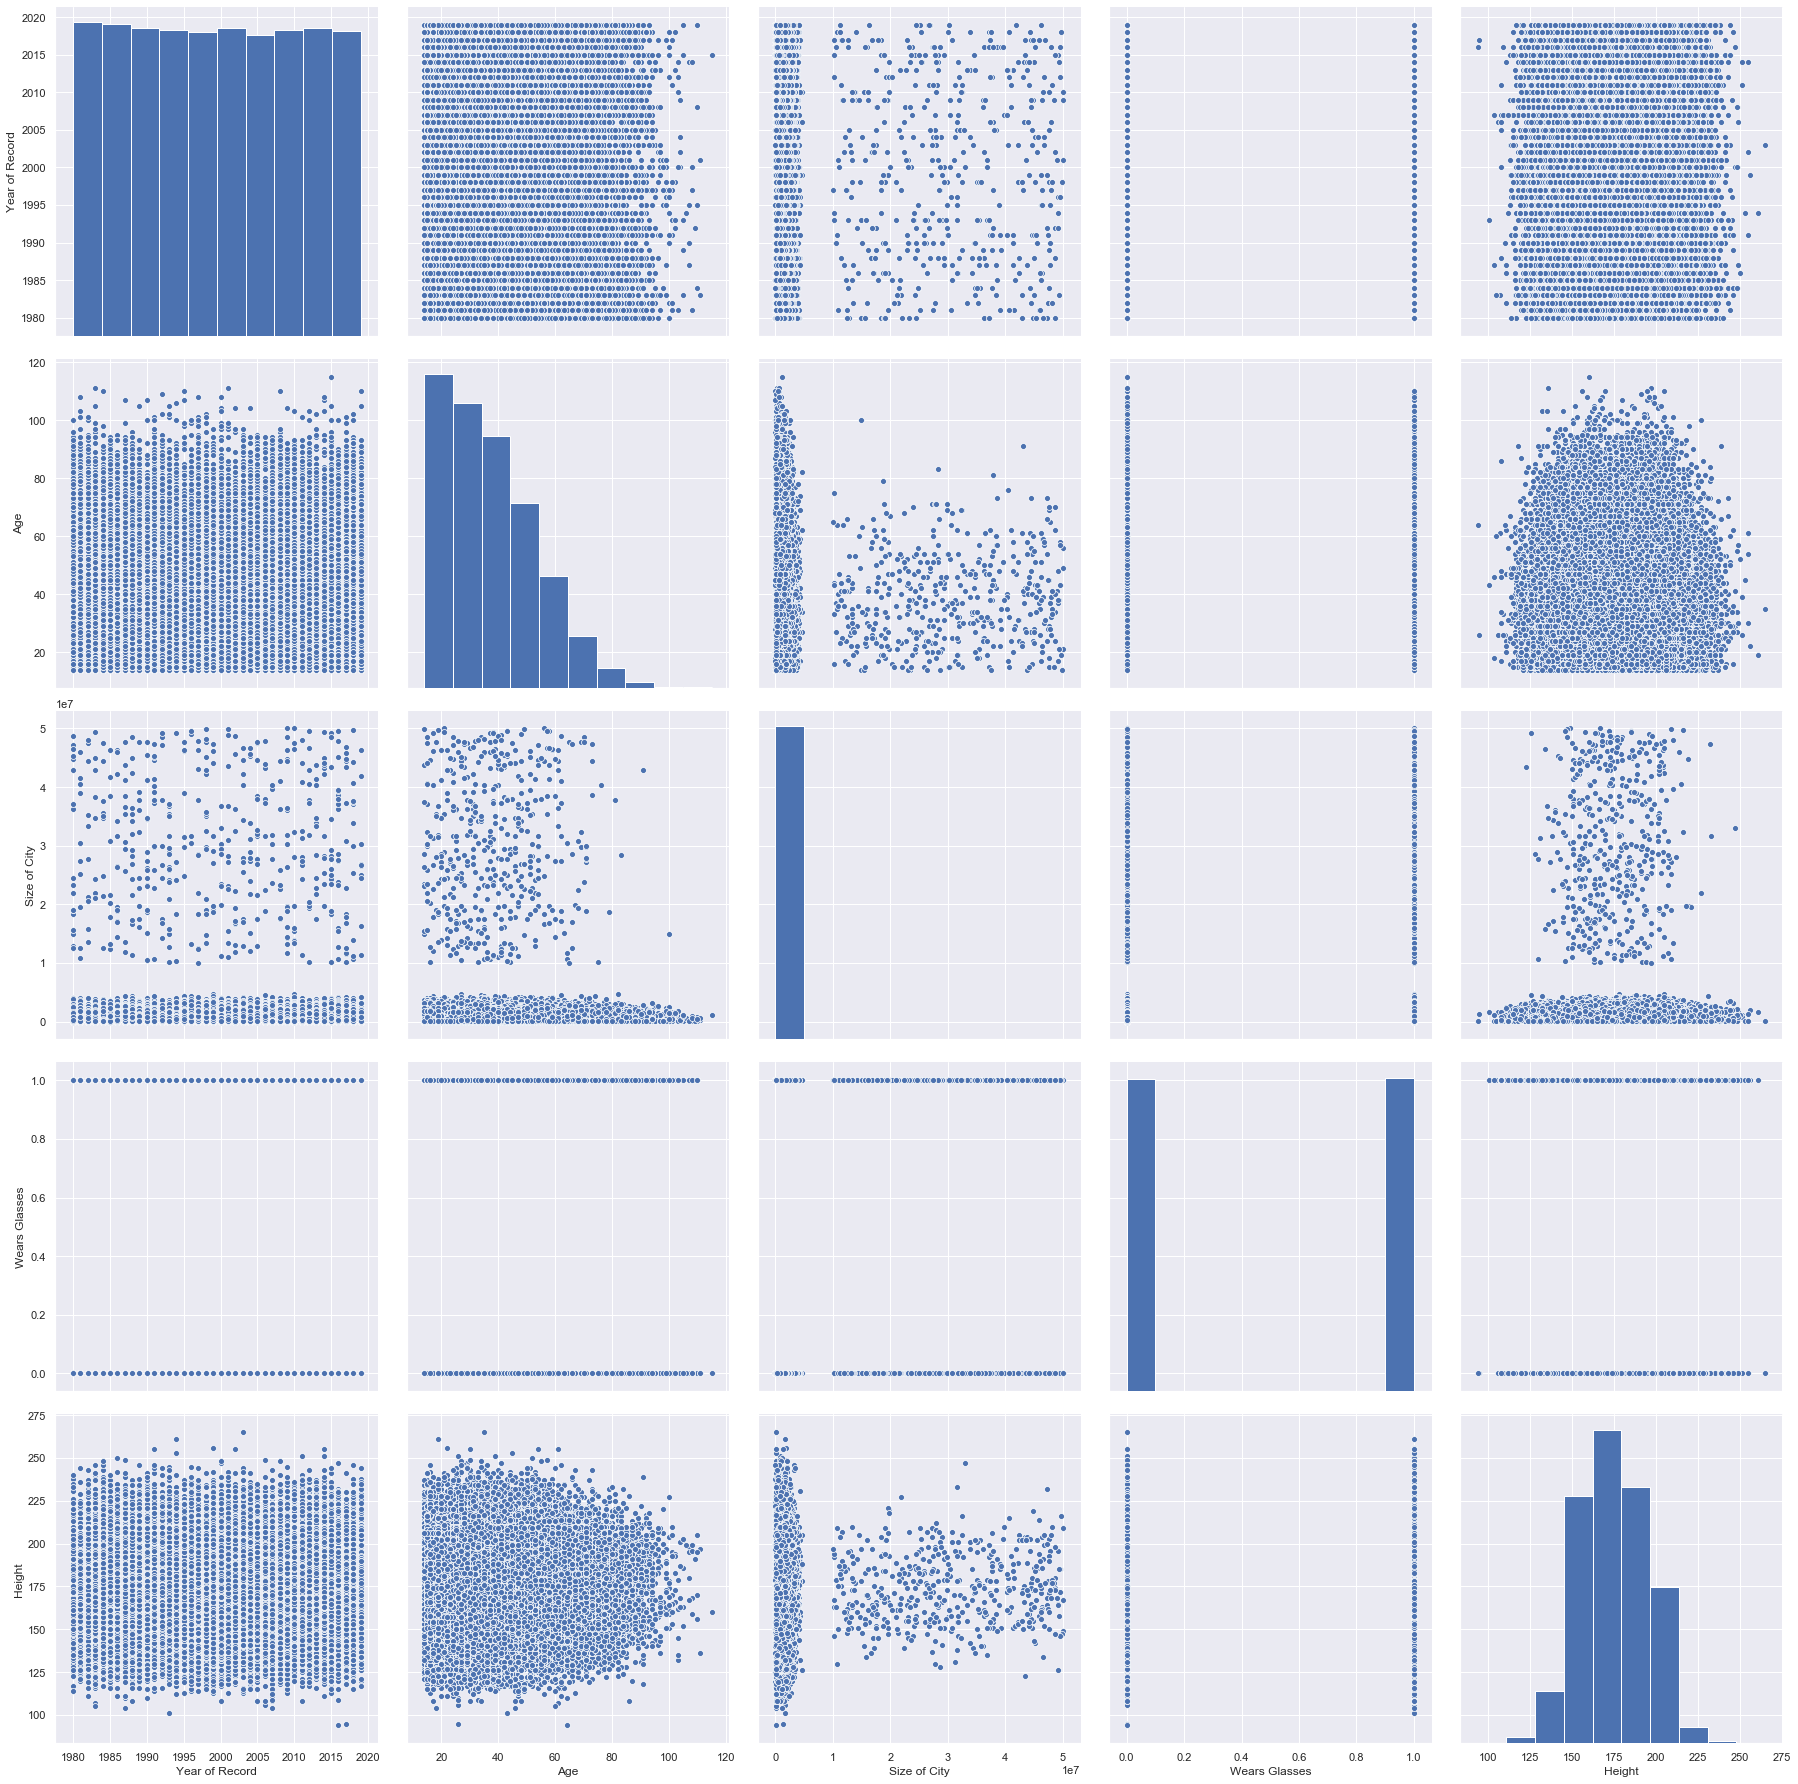

In [7]:
sns.set()
cols = ['Year of Record', 'Age', 'Size of City', 'Wears Glasses', 'Height']
sns.pairplot(train[cols], height = 5)
plt.show();

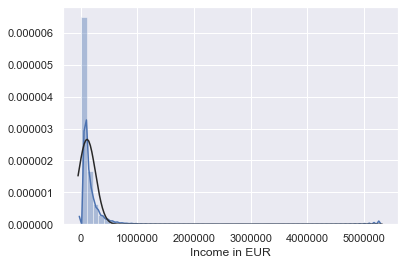

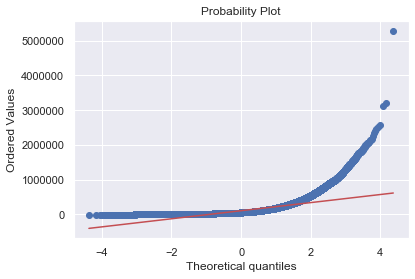

In [8]:
sns.distplot(train['Income in EUR'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['Income in EUR'], plot=plt)

In [62]:
all_data = pd.concat((train.loc[:, 'Year of Record': 'Height'],
                      test.loc[:, 'Year of Record': 'Height']))

In [63]:
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

log_income = np.log1p(train['Income in EUR'])
log_income = log_income.fillna(0)
y = log_income

# train.drop(columns = ['Instance', 'Income in EUR'], inplace = True)
# instaces = test['Instance']
# test.drop(columns = ['Instance'], inplace = True)

# train = pd.get_dummies(train, columns = ['University Degree', 'Hair Color', 'Gender', 'Country'])
# test = pd.get_dummies(test, columns = ['University Degree', 'Hair Color', 'Gender', 'Country'])

all_data = all_data.fillna(all_data.median())

# train = train.fillna(test.median())
# test = test.fillna(test.median())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


In [64]:
categorical_feats = train.select_dtypes(include = ["object"]).columns

for cat in categorical_feats:
    all_data[cat] = all_data[cat].fillna(all_data[cat].value_counts().index[0])

In [65]:
all_data.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Height
0,1997.0,unknown,41.0,Belarus,1239930,steel workers,Bachelor,0,Blond,193
1,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186
2,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170
3,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171
4,2010.0,female,46.0,United Arab Emirates,95389,lead trainer,no,0,Blond,188


In [68]:
country_counts = train.groupby('Country').count()
rare_countries = country_counts.loc[country_counts['Income in EUR'] < 100]     
all_data['Country'] = all_data['Country'].replace(dict.fromkeys(rare_countries, 'RARE'))

In [69]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

# all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

stdSc = StandardScaler()
# X_train.loc[:, numeric_feats] = stdSc.fit_transform(X_train.loc[:, numeric_feats])
# X_test.loc[:, numeric_feats] = stdSc.fit_transform(X_test.loc[:, numeric_feats])
all_data.loc[:, numeric_feats] = stdSc.fit_transform(all_data.loc[:, numeric_feats])


In [70]:
all_data = pd.get_dummies(all_data, columns = ['University Degree', 'Hair Color', 'Gender'])

In [71]:
from category_encoders import BinaryEncoder

# hashing_enc = HashingEncoder(cols=['Profession'], max_process=1, n_components=22000).fit(X_train, y)
binary_enc = BinaryEncoder(cols=['Profession', 'Country']).fit(all_data)
all_data = binary_enc.transform(all_data.reset_index(drop=True))

In [72]:
# from sklearn.model_selection import cross_val_score, train_test_split

# X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
# print("X_train : " + str(X_train.shape))
# print("X_test : " + str(X_test.shape))
# print("y_train : " + str(y_train.shape))
# print("y_test : " + str(y_test.shape))

In [73]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = log_income

In [79]:
y_train = train['Income in EUR']

# Models

In [80]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

In [81]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1, 1.5, 2, 2.7, 3.5], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())

Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4
Lasso RMSE on Training set : 123039.91025737251


Lasso picked 35 features and eliminated the other 5 features


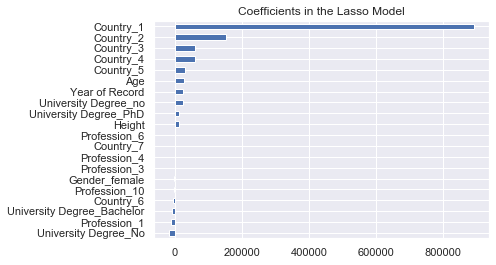

In [82]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [45]:
lasso_pred = np.expm1(lasso.predict(X_test))

In [46]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 1.0
Best alpha : 0.0001
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1
Best alpha : 0.0001


Now try again for more precision on alpha, with l1_ratio fixed at 1 and alpha centered around 0.0001
Best l1_ratio : 1
Best alpha : 6e-05
ElasticNet RMSE on Training set : 0.9996118041439939
ElasticNet picked 36 features and eliminated the other 4 features


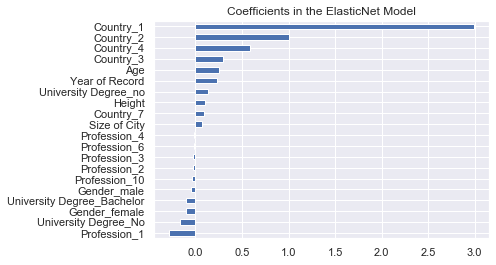

In [47]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [48]:
elastic_pred = np.expm1(elasticNet.predict(X_test))

In [51]:
lasso_prediction

array([11.02808552, 10.14171807, 11.09336844, ..., 11.36646706,
       11.20314287, 11.63948628])